## Common Task 1. Electron/photon classification

In [1]:
!wget -O photon.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
!wget -O electron.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5

--2025-03-29 12:27:03--  https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photon.hdf5’

photon.hdf5         100%[===================>] 114.16M  18.6MB/s    in 6.1s    

2025-03-29 12:27:09 (18.7 MB/s) - ‘photon.hdf5’ saved [119703858/119703858]

--2025-03-29 12:27:09--  https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application

In [2]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import models
from dataclasses import dataclass
from typing import ClassVar, Optional

from tqdm.notebook import tqdm

In [3]:
@dataclass
class Config:
    # dataset config
    file_paths: ClassVar[list[str]] = ["electron.hdf5", "photon.hdf5"]
    batch_size: int = 256
    num_workers: int = 24
    split_ratio: float = 0.8
    rotation_transform: float = 5.0

    # training config
    epochs: int = 15
    label_smoothing: float = 0.05
    lr: float = 1e-3
    weight_decay: float = 1e-4
    max_lr: float = 1e-3

    device: str = "cuda"

cfg = Config()

In [4]:
class ParticleDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.transform = transform
        self._load_data(file_paths)

    def _load_data(self, file_paths):
        data_x_list = []
        data_y_list = []
        for file_path in file_paths:
            with h5py.File(file_path, 'r') as f:
                data_x_list.append(np.array(f['X']))
                data_y_list.append(np.array(f['y']))
        self.data_x = np.concatenate(data_x_list, axis=0)
        self.data_y = np.concatenate(data_y_list, axis=0)
        self.total_samples = self.data_x.shape[0]

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = int(self.data_y[idx])
        x = torch.from_numpy(x.astype(np.float32)).permute(2, 0, 1)
        if self.transform:
            x = self.transform(x)
        return x, y

data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(cfg.rotation_transform),
    # transforms.Normalize(mean=[0.5, 0.5], std=[0.2, 0.2])
])

full_dataset = ParticleDataset(cfg.file_paths, transform=data_transforms)

train_size = int(cfg.split_ratio * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

In [5]:
def load_model(model_path: Optional[str] = None):
    model = models.resnet18(weights='IMAGENET1K_V1')
    original_conv1 = model.conv1
    model.conv1 = nn.Conv2d(
        in_channels=2,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias is not None
    )
    with torch.no_grad():
        # compute the mean of the original weights across the input channels
        #  and epeat the mean weights to match the new number of input channels
        mean_weight = original_conv1.weight.mean(dim=1, keepdim=True)
        model.conv1.weight[:] = mean_weight.repeat(1, 2, 1, 1)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    if model_path:
        model.load_state_dict(torch.load(model_path, map_location="cpu", weights_only=True))
    model.to(cfg.device)
    return model

model = load_model()

In [6]:
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=cfg.max_lr, epochs=cfg.epochs, steps_per_epoch=steps_per_epoch)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_one_epoch(model, loader, optimizer, scheduler, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_description(f"Loss: {loss.item():.5f} Running Loss: {running_loss / total:.5f}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [7]:
for epoch in tqdm(range(cfg.epochs)):
    
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, cfg.device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, cfg.device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{cfg.epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 1/15: Train Loss: 0.6861, Train Acc: 0.5592 | Val Loss: 0.6683, Val Acc: 0.5936


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 2/15: Train Loss: 0.6581, Train Acc: 0.6146 | Val Loss: 0.6481, Val Acc: 0.6313


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 3/15: Train Loss: 0.6314, Train Acc: 0.6549 | Val Loss: 0.6368, Val Acc: 0.6457


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 4/15: Train Loss: 0.6149, Train Acc: 0.6771 | Val Loss: 0.6091, Val Acc: 0.6850


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 5/15: Train Loss: 0.6055, Train Acc: 0.6885 | Val Loss: 0.6085, Val Acc: 0.6852


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 6/15: Train Loss: 0.5983, Train Acc: 0.6961 | Val Loss: 0.6401, Val Acc: 0.6414


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 7/15: Train Loss: 0.5926, Train Acc: 0.7019 | Val Loss: 0.5900, Val Acc: 0.7024


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 8/15: Train Loss: 0.5874, Train Acc: 0.7063 | Val Loss: 0.5890, Val Acc: 0.7059


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 9/15: Train Loss: 0.5833, Train Acc: 0.7103 | Val Loss: 0.5825, Val Acc: 0.7122


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 10/15: Train Loss: 0.5793, Train Acc: 0.7145 | Val Loss: 0.5783, Val Acc: 0.7161


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 11/15: Train Loss: 0.5757, Train Acc: 0.7179 | Val Loss: 0.5748, Val Acc: 0.7196


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 12/15: Train Loss: 0.5726, Train Acc: 0.7209 | Val Loss: 0.5712, Val Acc: 0.7230


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 13/15: Train Loss: 0.5691, Train Acc: 0.7239 | Val Loss: 0.5680, Val Acc: 0.7248


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 14/15: Train Loss: 0.5671, Train Acc: 0.7257 | Val Loss: 0.5674, Val Acc: 0.7258


  0%|          | 0/1557 [00:00<?, ?it/s]

Epoch 15/15: Train Loss: 0.5662, Train Acc: 0.7264 | Val Loss: 0.5670, Val Acc: 0.7259


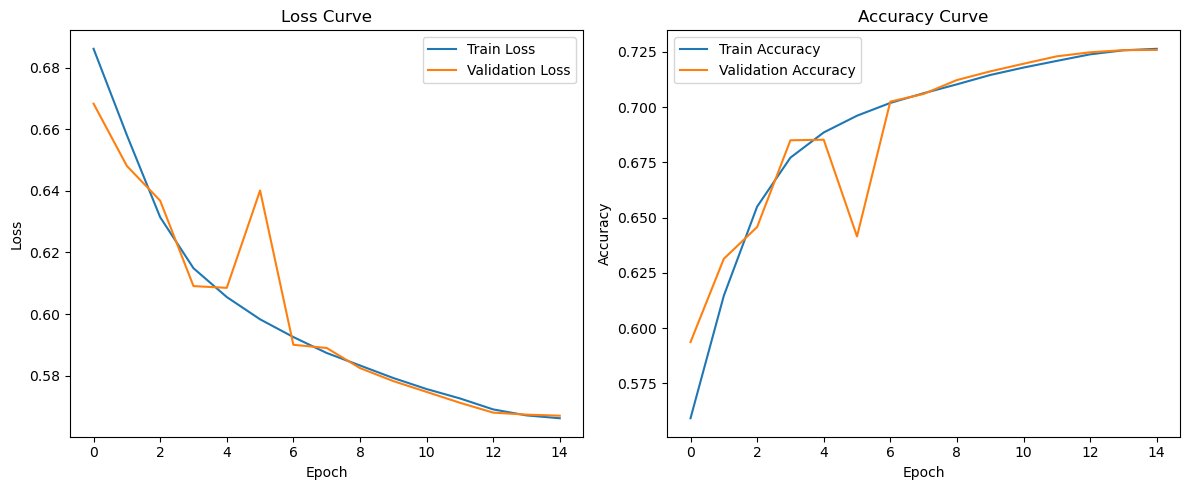

Final Validation Loss: 0.5667, Final Validation Accuracy: 0.7258


In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.tight_layout()
plt.show()

val_loss, val_acc = evaluate(model, val_loader, criterion, cfg.device)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_acc:.4f}")

torch.save(model.state_dict(), "resnet18_particle_classifier.pth")

### Evaluate the final model

In [9]:
model = load_model("resnet18_particle_classifier.pth")
val_loss, val_acc = evaluate(model, val_loader, criterion, cfg.device)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_acc:.4f}")

Final Validation Loss: 0.5667, Final Validation Accuracy: 0.7262
